<a href="https://colab.research.google.com/github/lamini-H/SDV/blob/main/SVD_for_Recommendation_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Title
*Using Singular Value Decomposition (SVD) for Recommendation Systems*

## Introduction

In today's digital world, recommendation systems are widely used across platforms such as Netflix, Amazon and Spotify to suggest relevant content to users. These systems aim to personalize user experience by predicting what a user might like based on past interactions.

This project explores how **Singular Value Decomposition (SVD**), a mathematical matrix factorization technique, can be used to build a simple yet powerful **collaborative filtering recommendation system.**

## Why SVD
SVD is a dimensionality reduction technique that transforms a high-dimensional matrix (eg a user-item interaction matrix) into a set of latent features that capture the underlying structure in the data. It helps in

*   Reducing data sparsity
*   Removing noise
*   Extracting hidden relationships between users and items

By applying truncated SVD on a user-item rating matrix, we can:

*   Predict **missing ratings** (ie, recommended new items)
*   Identify **latent factors** influencing preferences

## Project Objectives


1.   **Mathetically explain** how SVD works
2.   **Implement SVD in Python** using a simple ratings matrix
3.   **Visualize the matrices** before and after applying SVD
4.   **Reconstruct the matrix** using top k singular values and make predictions
5.   **Evaluate** the quality of predictions using appropriate metrics
6.   **Document references** for reproducibility and academic rigor













## Step 1: Mathematical Explanation of SVD

### Singular Value Decomposition (SVD)

SVD is a matrix factorization technique that decomposeses a matrix A into three other matrice;

$$A = U \Sigma V^{\mathsf{T}}$$


### Where;
$$
\begin{aligned}
A &\in \mathbb{R}^{m \times n} && \text{original user-item matrix} \\
U &\in \mathbb{R}^{m \times m} && \text{left singular vectors (users)} \\
\Sigma &\in \mathbb{R}^{m \times n} && \text{diagonal matrix of singular values} \\
V^{\mathsf{T}} &\in \mathbb{R}^{n \times n} && \text{right singular vectors (items)}
\end{aligned}
$$


### Properties
*   U and V are orthogonal matrices.
*   The singular values in Σ are sorted in descending order
*   The top 𝐤 singular values capture most of the informaiton in the matrix

### Use in Recommendation Systems
*   Treat the user-item rating matrix as A
*   Use truncated SVD (only top 𝐤  values) to reduce noise and capture latent features
*   Reconstruct the matrix $$A_k = U_k \Sigma_k V_k^{\mathsf{T}}$$ for prediction




## Step 2: Dataset & Problem Setup
To make the project more realistic, we used MovieLens 100K a very popular and clean dataset used for recommnender system projects. It contains
*   100,000 ratings (1 -5)
*   943 users
*   1,682 movies
*   Preprocessed and ready-to-use in CSV format






### Load the MovieLens 100K dataset

In [ ]:
# Download the MovieLens 100K dataset
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -q ml-100k.zip



--2025-05-16 00:18:50--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  20.1MB/s    in 0.2s    

2025-05-16 00:18:50 (20.1 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]



In [ ]:
# Load the data into a DataFrame
import pandas as pd

In [ ]:
# u.data contains tab-separated values: user_id, item_id, rating, timestamp
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
ratings_df = pd.read_csv('ml-100k/u.data', sep='\t', names=column_names)

ratings_df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Create a User-Item Matrix
We need to pivot the ratings into a user-item matrix (rows = users, columns = items, values = ratings):

In [ ]:
# Pivot to get user-item matrix
user_item_matrix = ratings_df.pivot_table(index='user_id', columns='item_id', values='rating').fillna(0)

# Convert to numpy array for SVD
R = user_item_matrix.values

# Check shape
R.shape

#R the full rating matrix (users x items)

(943, 1682)

### Visualize Sparsity of the User-Item Matrix
Here matplotlib and seaborn is used to plot the matrix and hightlight where ratings are present.

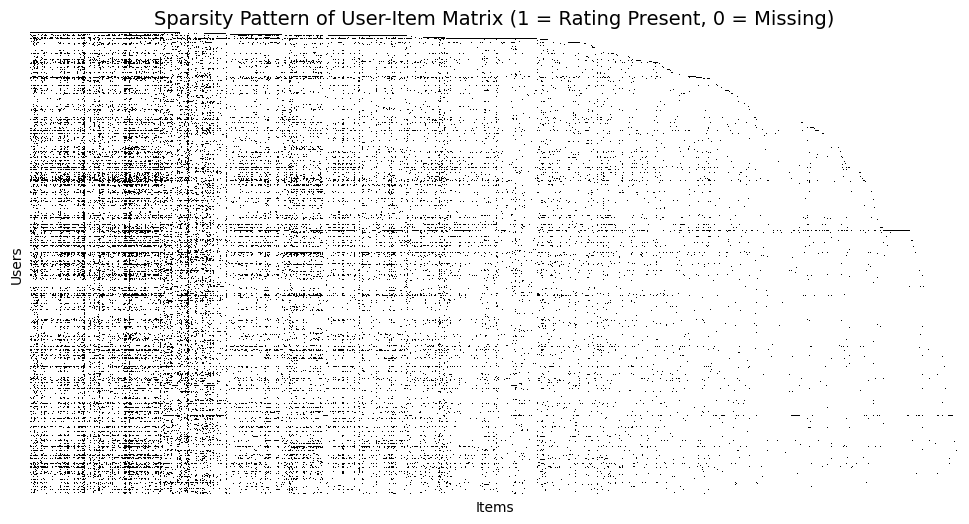

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a binary matrix where 1 = rating present, 0 = no rating
sparsity_matrix = (R > 0).astype(int)

plt.figure(figsize=(12, 6))
sns.heatmap(sparsity_matrix, cbar=False, cmap='Greys', xticklabels=False, yticklabels=False)
plt.title('Sparsity Pattern of User-Item Matrix (1 = Rating Present, 0 = Missing)', fontsize=14)
plt.xlabel('Items')
plt.ylabel('Users')
plt.show()


Since the sparsity plot is dense and hard to interpret because the MovieLens matrix is quite large, I sampled randomly top 30 users with the most ratings and Top 30 items most rated

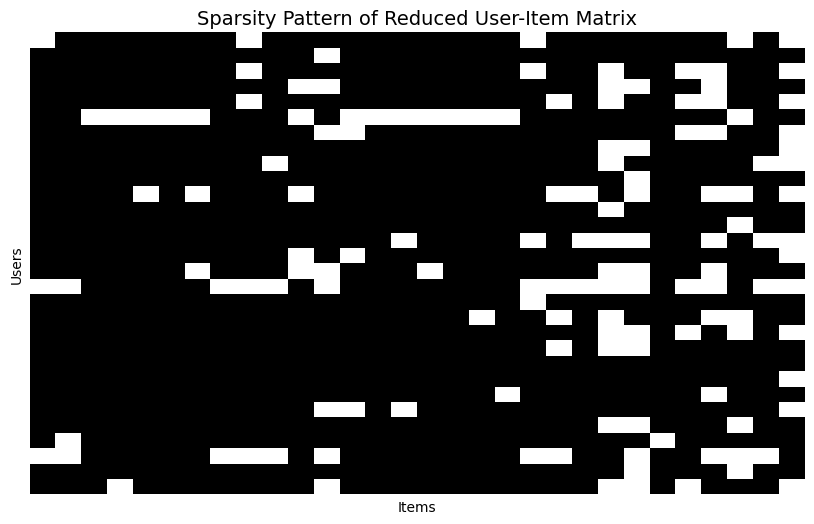

Reduced matrix shape: (30, 30)


In [ ]:
# Find top users and items with the most ratings
top_users = ratings_df['user_id'].value_counts().head(30).index
top_items = ratings_df['item_id'].value_counts().head(30).index

# Filter the dataset
filtered_df = ratings_df[ratings_df['user_id'].isin(top_users) & ratings_df['item_id'].isin(top_items)]

# Create the reduced user-item matrix
small_matrix = filtered_df.pivot_table(index='user_id', columns='item_id', values='rating').fillna(0)
R_small = small_matrix.values

# Plot sparsity again
sparsity_small = (R_small > 0).astype(int)

plt.figure(figsize=(10, 6))
sns.heatmap(sparsity_small, cbar=False, cmap='Greys', xticklabels=False, yticklabels=False)
plt.title('Sparsity Pattern of Reduced User-Item Matrix', fontsize=14)
plt.xlabel('Items')
plt.ylabel('Users')
plt.show()

# Also show the shape
print("Reduced matrix shape:", R_small.shape)


From the reduced graph we can clearly see,


*   White squares which shows ratings are presents
*   Black squares are missing entries



# Step 3: Apply
In this section I will try to perform the following task
*  Explanation of SVD and Truncation
*  Implement SVD decomposition
*  Choose a smal k value for truncation
*  Reconstruct the matrix
*  Visualize the compare original vs reconstructed

## Explanation of SVD and Truncation
Let's assume we have a user-item matrix
$$R \in \mathbb{R}^{m \times n}$$

where;
*   m = number of users
*   n = number of items
*   Aij is the rating user i gave to item j

### Singular Value Decomposition (SVD)

The SVD of matrix R is:

$$R = U \Sigma V^{\mathsf{T}}$$


### Where;
$$
\begin{aligned}
U &\in \mathbb{R}^{m \times m} && \text{is the left singular matrix (users -> latent features)} \\
\Sigma &\in \mathbb{R}^{m \times n} && \text{is a diagonal matrix of singular values (strength of each latent feature)} \\
V^{\mathsf{T}} &\in \mathbb{R}^{n \times n} && \text{is the right singular matrix (items -> latent features)}
\end{aligned}
$$

###  Truncated SVD (Dimensionality Reduction)
We truncate the SVD to keep only the top k components (usually k << min(m,n)):
$$R_k = U_k \Sigma_k V_k^{\mathsf{T}}$$

where;

$$U_k \in \mathbb{R}^{m \times k}$$  

$$\Sigma_k \in \mathbb{R}^{k \times k}$$  

$$V_k^{\mathsf{T}} \in \mathbb{R}^{k \times n}$$  


This gives a low-rank approximation of the original matrix R, capturing most of its patterns with fewer dimensions

SVD there helps to


*   Compress the matrix into latent features
*   Predict missing ratings (ie fill in the 0s) by reconstructing the matrix
*   Capture relationships like " users similar in taste" or "items that are alike"



## Apply SVD and Reconstruct the Matrix
we are using the reduced user-item matrix

In [ ]:
import numpy as np

# R_small is the reduced user-item matrix
print("Original matrix shape:", R_small.shape)

# Step 1: Apply full SVD
U, sigma, Vt = np.linalg.svd(R_small, full_matrices=False)

# Step 2: Convert sigma (1D array) to diagonal matrix
Sigma = np.diag(sigma)

# Step 3: Choose number of components (e.g., k = 5)
k = 5
U_k = U[:, :k]
Sigma_k = Sigma[:k, :k]
Vt_k = Vt[:k, :]

# Step 4: Reconstruct the matrix with k components
R_approx = np.dot(np.dot(U_k, Sigma_k), Vt_k)

# Step 5: Show original vs reconstructed matrix (first 5x5 for clarity)
print("\nOriginal (partial):\n", np.round(R_small[:5, :5], 2))
print("\nReconstructed (partial):\n", np.round(R_approx[:5, :5], 2))


Original matrix shape: (30, 30)

Original (partial):
 [[0. 5. 5. 5. 5.]
 [3. 2. 5. 5. 4.]
 [2. 4. 5. 5. 5.]
 [4. 4. 5. 5. 5.]
 [4. 4. 5. 5. 3.]]

Reconstructed (partial):
 [[2.82 4.08 4.61 5.39 3.52]
 [2.95 2.45 4.74 3.87 4.38]
 [2.92 4.58 5.57 5.43 4.12]
 [4.18 3.86 4.9  3.28 4.21]
 [3.02 4.54 4.73 4.93 3.38]]


#### Interpretation

*   `U_k, Sigma_k` and `Vt_k` represent the compressed latent space
*   `R_approx` is the predicted matrix - it fills in previously missing values (zeros) based on patterns




## Visualize the Reconstructed Matrix
let compare the original reduced matrix(with missing values =0) and the reconstructed matrix (with SVD-filled predictions)


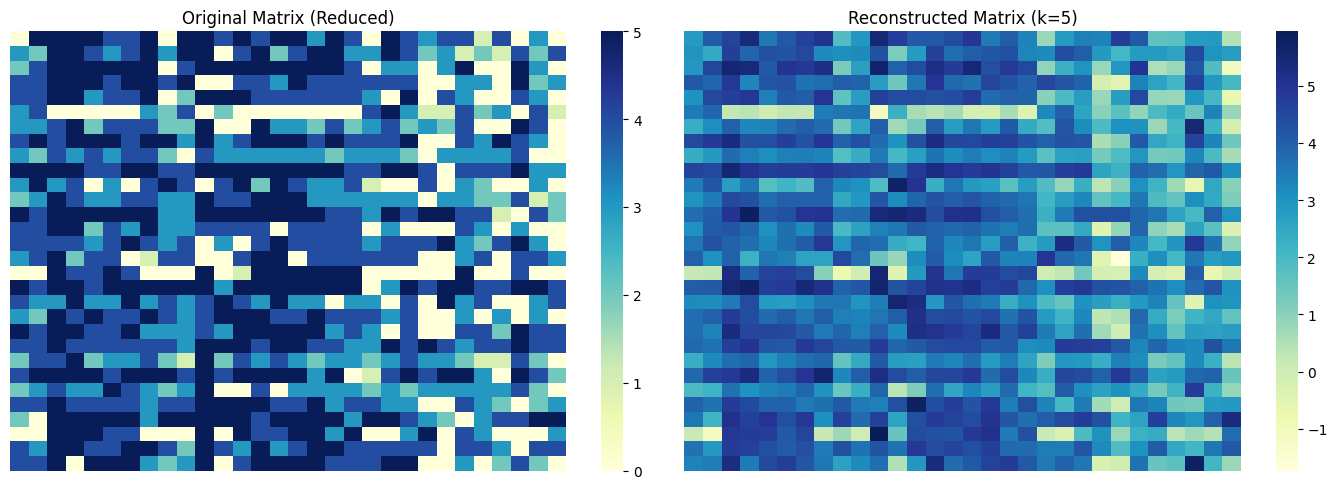

In [ ]:
plt.figure(figsize=(14, 5))

# Original matrix heatmap
plt.subplot(1, 2, 1)
sns.heatmap(R_small, cmap='YlGnBu', cbar=True, xticklabels=False, yticklabels=False)
plt.title('Original Matrix (Reduced)')

# Reconstructed matrix heatmap
plt.subplot(1, 2, 2)
sns.heatmap(R_approx, cmap='YlGnBu', cbar=True, xticklabels=False, yticklabels=False)
plt.title(f'Reconstructed Matrix (k={k})')

plt.tight_layout()
plt.show()


#### Interpretation

*  **Left:** Sparse original matrix (zeros = missing ratings).
*   **Right:** Densified matrix filled in with SVD-based predictions.


#### Visualize the Reconstructed Matrix

We'll compute:
    Error Matrix = $R_{original}$ - $R_{reconstruted}$

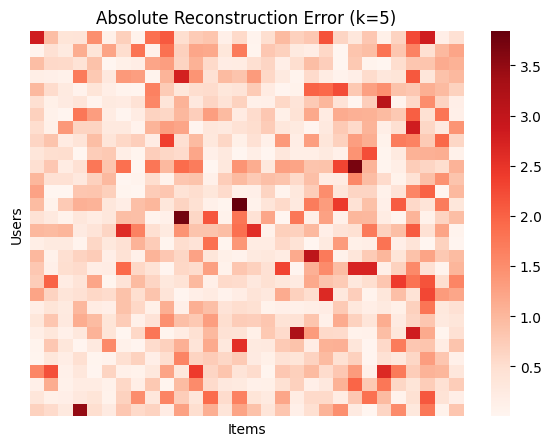

Max error: 3.83901779563302
Mean error (non-zero): 0.6206857733809719


In [ ]:
# Compute absolute error (only where ratings were originally present)
error_matrix = np.abs(R_small - R_approx)

plt.figure(figsize=(7, 5))
sns.heatmap(error_matrix, cmap='Reds', xticklabels=False, yticklabels=False, cbar=True)
plt.title(f'Absolute Reconstruction Error (k={k})')
plt.xlabel("Items")
plt.ylabel("Users")
plt.show()

# Optional: Print some error stats
print("Max error:", np.max(error_matrix))
print("Mean error (non-zero):", np.mean(error_matrix[R_small != 0]))


#### Interpretation

*  **Bright red areas:**high reconstruction error
*   **Dark areas** good match between actual and predicted

## Step 4: Predict Ratings for a Specific User
We’ll pick a user from the reduced matrix and:

*   Predict their ratings using the reconstructed matrix.
*   Recommend unrated items with the highest predicted scores.





In [ ]:
# Pick a user index (0 to R_small.shape[0] - 1)
user_index = 0

# Get actual and predicted ratings for that user
actual_ratings = R_small[user_index]
predicted_ratings = R_approx[user_index]

# Find indices of items the user has NOT rated
unrated_indices = np.where(actual_ratings == 0)[0]

# Recommend top N items
N = 5
recommended_indices = unrated_indices[np.argsort(predicted_ratings[unrated_indices])[::-1][:N]]

print(f"Top {N} recommendations for User {user_index + 1}:")
for idx in recommended_indices:
    print(f"Item {small_matrix.columns[idx]} - Predicted Rating: {predicted_ratings[idx]:.2f}")


Top 5 recommendations for User 1:
Item 313 - Predicted Rating: 2.83
Item 1 - Predicted Rating: 2.82
Item 117 - Predicted Rating: 1.85
Item 222 - Predicted Rating: 0.81
Item 748 - Predicted Rating: 0.46


## Step 5: Evaluate Overall Model Performance
We'll use Root Mean Squared Error (RMSE) to measure how close the reconstructed matrix $\hat{R}_{k}$ is to the original ratings (only for the non-zero enteries)

RMSE Formular

$$
\text{RMSE} = \sqrt{\frac{1}{|M|} \sum_{(i,j) \in M} (R_{ij} - \hat{R}_{ij})^2}
$$

Where;
* M = set of indices wiht original ratings ie $$R_{ij} \neq 0$$
*$$R_{ij}$$ = predicted rating from  $$R_{approx}$$






In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Flatten both matrices and filter out the zero entries in original
original = R_small.flatten()
predicted = R_approx.flatten()

# Only evaluate where original rating is non-zero
mask = original > 0
rmse = sqrt(mean_squared_error(original[mask], predicted[mask]))

print(f"RMSE on known ratings: {rmse:.4f}")


RMSE on known ratings: 0.8026


## Step 6: RMSE vs. Number of Components k
In this step we

*   Write a function that loops over values of k
*   Compute RMSE for each reconstructed matrix
*   Plot RMSE vs K



In [ ]:
def compute_rmse_vs_k(R, k_values):
    rmse_scores = []

    for k in k_values:
        # Full SVD
        U, sigma, Vt = np.linalg.svd(R, full_matrices=False)
        Sigma = np.diag(sigma)

        # Truncate matrices to k components
        U_k = U[:, :k]
        Sigma_k = Sigma[:k, :k]
        Vt_k = Vt[:k, :]

        # Reconstruct the matrix
        R_k = np.dot(np.dot(U_k, Sigma_k), Vt_k)

        # Compute RMSE on known ratings
        original = R.flatten()
        predicted = R_k.flatten()
        mask = original > 0
        rmse = np.sqrt(mean_squared_error(original[mask], predicted[mask]))
        rmse_scores.append(rmse)

    return rmse_scores


### Plot the RMSE vs. K

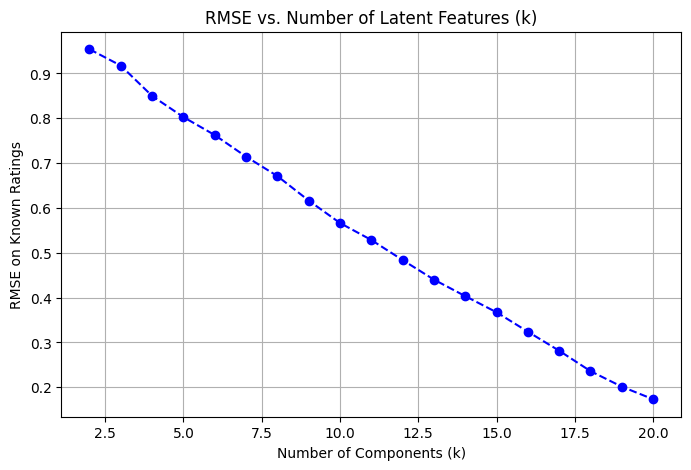

In [ ]:
k_range = list(range(2, 21))
rmse_results = compute_rmse_vs_k(R_small, k_range)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(k_range, rmse_results, marker='o', linestyle='--', color='blue')
plt.title("RMSE vs. Number of Latent Features (k)")
plt.xlabel("Number of Components (k)")
plt.ylabel("RMSE on Known Ratings")
plt.grid(True)
plt.show()


## Interpretation
It is observed from the graph that,
* RMSE decreases consistently as k increases from 2 to 20
* This shows that more latent features capture more complex relationships between users and items
* However, after a point (around k=15), the improvements start to diminish, indicating a dimishing return - classic bias-variance tradeoff

References

* Koren, Y., Bell, R., & Volinsky, C. (2009). Matrix factorization techniques for recommender systems. Computer, 42(8), 30-37.

* Simon Funk. (2006). Netflix Update: Try This at Home.

* MovieLens Dataset: https://grouplens.org/datasets/movielens/

* Golub, G. H., & Van Loan, C. F. (2013). Matrix Computations.

* Scikit-learn Documentation: https://scikit-learn.org/

* NumPy SVD: https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html